#### Kuba Krzychowiec
#### Kwiecień 2023
#### Generowanie podpisów do obrazków

# Wykorzystane źródła
- [Machine learning mastery](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

- [Pritish Mistra's youtube video](https://www.youtube.com/watchv=aaP7JJZuvGs&t=398s&pp=ygUQaW1hZ2UgY2FwdGlvbmluZw%3D%3D)

- [Code Emporium's youtube video](https://www.youtube.com/watch?v=c_bVBYxX5EU&t=442s&pp=ygUQaW1hZ2UgY2FwdGlvbmluZw%3D%3D)

- [Keras documentation](https://keras.io/guides/)

- [Tensorflow documentation](https://www.tensorflow.org)

- [LSTM - Towards Data Science](https://towardsdatascience.com/long-short-term-memory-lstm-in-keras-2b5749e953ac)



---

# Spis tresci

[0. Opis problemu](#0.-Opis-problemu)

[1. Ekstrakcja wektora cech](#1.-Ekstrakcja-wektora-cech-z-obrazow)

[2. Wstepne przetwarzanie danych tekstowych](#2.-Wstepne-przetwarzanie-danych-tekstowych)

[3. Przygotowanie do uczenia modelu](#3.-Przygotowanie-do-uczenia-modelu)

[4. Wczytanie przetworzonych danych](#4.-Wczytanie-przetworzonych-danych)

[5. Trenowanie modelu](#5.-Trenowanie-modelu)

[6. Ewaluacja](#6.-Ewaluacja)

[7. Przykłady dzialania modelu](#7.-Przykłady-dzialania-modelu)

[8. Porównanie modeli typu _backbone_, VGG16 i InceptionV3](#8.-Przykłady-opisu-do-zdjęcia-i-metryki-dla-obu-modeli)

---

# Wstęp

##  Opis problemu

Podjętym problemem jest generowanie podpisów do obrazów. Jest to skomplikowany proces, gdzie z wykorzystaniem sztucznej inteligencji, a dokładniej mówiąc z wykorzystaniem sieci neuronowych, po podaniu modelowi obrazu, ten generuje opis tego obrazka. Przykładem tego może być podanie modelowi zdjęcia psa biegającego po polu, na co ten potrafi odpowiedzieć opisem w stylu _"pies biegający wśród trawy"_.

Mówiąc, że jest to skomplikowany proces, należy myśleć o bardzo zasosbochłonnym procesie uczenia. Nie jest to jednak jedyny problem, z jakim przychodzi się mierzyć podczas takiego zadania. Drugim z głównych problemów jest zbiór danych. Sieci neuronowe są ogromnym (w zależności od problemu) modelem statystycznym, który uczy się wykorzystując w tym celu dane, które zostały mu przekazane w procesie uczenia. 

Wychodzi się z założenia, że im większa ilość danych, tym bardziej odpowiadające rzeczywistości opisy model będzie generował. Proszę jednak zauważyć skalę problemu, człowiek naturalnie potrafi rozróżniać obiekty które widzi, jednak w tym celu wykorzystuje całą swoją wiedzę o świecie, którą nabył dotychczas. W przypadku tego projektu, model był uczony na podstawie tylko i wyłącznie 6000 zdjęć ze zbioru danych zatytułowanego _Flickr8kDataset_, gdzie do każdego zdjęcia przygotowane jest po 5 opisów. Pozostałe 2000 zdjęć można wykorzystać do ewaluacji modelu i jego dostrajania.

W procesie generowania opisów do obrazu, należy wspomnieć iż sam model nie otrzymuje obrazu jako takiego. Obraz wcześniej jest poddawany obróbce i przechodzi proces tzw. ekstrakcji wektora cech. Jest to proces, którego efektem jest przedstawienie zdjęcia w postaci wektorów liczb świadczących o elementach znajdujących się na obrazie.  W tym celu, można wykorzystać tzw. modele typu _backbone_, czyli wcześniej wytrenowanych potężnych modeli głębokiego uczenia, które posłużą do wcześniej wspomnianej ekstrakcji cech. 

##  Cel projektu

Celem niniejszego projektu, jest nie tylko stworzenie samego modelu generującego takowe podpisy, jednak porównanie też modeli tzw. _backbone_, czyli wcześniej wytrenowanych modeli, które posłużą za ekstrakcję wektorów cech. 

Ewaluacja wyników i wydajności modeli, zostanie dokonana na podstawie obliczenia metryk, które pozwolą nam porównać modele ze sobą. Prócz tego, porównamy również same podpisy, które modele wygenerują.

## Metodologia i konwencje

Do wykonania tego zadania, wykorzystamy język programowania _Python_ i wiele bibliotek, które ułatwiają tworzenie głębokich sieci neuronowych.

Prócz samego kodu, krok po kroku zostanie objaśniane co jest wykonywane i w jakim celu. Niniejszy _notebook_ nie tylko ma posłużyć jako sprawozdanie z projektu, jednak ma też spełnić swoje zadanie jako swego rodzaju poradnik, w jaki sposób przebiega proces przygotowywania danych, trenowania modelu, ewaluacji modelu.

Czytelnik tego _notebooka_, powinien być osobą rozumiejącą podstawowe pojęcia z zakresu sztucznej inteligencji, sieci neuronowych, programowania. 

## Wykorzystanie sztucznej inteligencji

W niniejszym projekcie, jak wcześniej zostało wspomniane, porównane zostaną dwa modele VGG16 oraz InceptionV3. Oba te modele są tzw. modelami typu _backbone_.

Poniżej przedstawiono poglądowe architektury poniższych modeli. Należy zwrócić jednak uwagę, że w naszym wypadku, jako że używamy tych modeli do ekstrakcji wektora cech, to ostatnia warstwa jest odłączona od modelu. Ta ostatnia warstwa jest też jedną z najbardziej złożonych, gdyż jest tzw. warstwą w pełni połączona (eng. _fully connected_). Ma to ogromny znaczenie, gdyż domyślnie oba te modele służą jako modele do klasyfikacji. Pominięcie ostatniej warstwy, jest jednoznaczne z pominięciem klasyfikacji do jednej z kategorii, dla których owy model był uczony. Dzięki temu, na wyjściu modelu jest tylko i wyłącznie sam wektor cech, który ma znaczenie z perspektywy naszego problemu.

Prócz samych modeli typu _backbone_, wykorzystamy też rekurencyjne sieci neuronowe, których najczęściej używa się podczas NLP (eng. _natural language processing_). Nasz model, poza zdjęciami będzie też uczony na podstawie opisów do przygotowanych obrazów. Rekurencyjne sieci neuronowe są niezawodne do predykcji szeregów czasowych, czy też wyżej wspomnianej obróbki, predykcji oraz ogólnych zastosowań dotyczących naturalnego języka.

### Model VGG16

Architektura: VGG16 ma bardzo prostą i jednolitą architekturę, składającą się z 16 warstw, w tym 13 warstw konwolucyjnych (oznaczanych jako _Conv_) i 3 warstw w pełni połączonych (oznaczanych jako _Dense_). Model VGG16 został wstępnie wytrenowany na dużym zbiorze danych ImageNet, który zawiera ponad milion obrazów z 1000 różnych klas. Model VGG16 jest ogromnym tworem o ponad 130 milionach parametrów.

VGG16 jest często używany jako model bazowy w zadaniach transferu uczenia (ang. transfer learning), gdzie wagi wstępnie wytrenowanej sieci są wykorzystywane do ekstrakcji cech z obrazów i dalszego trenowania na mniejszych zbiorach danych dla specyficznego zadania, tak jak w naszym przypadku.

Przy naszym zastosowaniu, należy zwrócić uwagę, że pomijamy ostatnią warstwę typu _dense_.

<div style="text-align:center">
    <img src="utils/vgg.png" alt="Image" width="600">
</div>


### Architektura InceptionV3

InceptionV3 jest jednym z wielu zaawansowanych modeli sieci neuronowych do analizy obrazów. Opracowany został przez zespół badawczy Google w 2015 roku. Jest rozwinięciem poprzednich modeli Inception i wykorzystuje architekturę konwolucyjną do przetwarzania obrazów.

InceptionV3 osiąga bardzo dobre wyniki w wielu popularnych zadaniach związanych z analizą obrazów, takich jak klasyfikacja obrazów czy detekcja obiektów. Dzięki swojej architekturze i zdolności do wykrywania cech o różnych skalach, model ten jest w stanie dokładnie rozpoznawać obiekty na obrazach, włącznie ze szczegółami. Model jest znany ze swoich warstw tzw. _inception layers_. W tychże warstwach, _wybierany_ jest odpowiedni filtr 1x1, 3x3, lub 5x5. Duże znaczenie mają też filtry właśnie 1x1, które pozwalają na ograniczenie wielowymiarowości danych, tym samym upraszczając proces uczenia.

Mimo, że uważany za duży model, ten zawiera _tylko_ (aż) 23 miliony parametrów i łącznie 42 warstwy. Należy też zwrócić uwagę, że przy naszym zastosowaniu, pomijamy ostatnią warstwę typu _dense_.

<div style="text-align:center">
    <img src="utils/inception.png" alt="Image" height=200>
</div>


---

## Biblioteki

In [1]:
import tensorflow as tf
import os
import re

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model, pad_sequences, load_img, img_to_array, to_categorical
from tensorflow.image import decode_jpeg
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.io import read_file
from pickle import dump, load
from nltk.translate.bleu_score import corpus_bleu
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from numpy import array, argmax
from matplotlib import pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

2023-05-29 08:44:30.987483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Ekstrakcja wektora cech z obrazów

## 1.1 Funkcja do wyświetlania obrazków

Poniższa funkcja pozwala na wyświetlenie obrazka z przygotowanymi podpisami w zbiorze danych.

In [2]:
def show_img(img_id):
    """
    Wyswietla obraz i jego opisy.
    
    :param: str path - sciezka do pliku
    
    :returns: None
    """
    
    jpg = decode_jpeg(read_file(f"data/fetched/{img_id}"), channels=3)
    file = open('data/info_on_images/Flickr8k.token.txt')
    im = plt.imshow(jpg)
    plt.axis('off')
    for r in file:
        if r.split('\t')[0][:-2] == img_id:
            print(r)
    file.close()

1089181217_ee1167f7af.jpg#0	a brown dog running down a paved pathway

1089181217_ee1167f7af.jpg#1	A brown dog running next to grass .

1089181217_ee1167f7af.jpg#2	A dog is running down a road .

1089181217_ee1167f7af.jpg#3	A light brown dog runs down a path happily .

1089181217_ee1167f7af.jpg#4	Energetic brown dog running



2023-05-26 21:55:29.581891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 21:55:29.583872: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


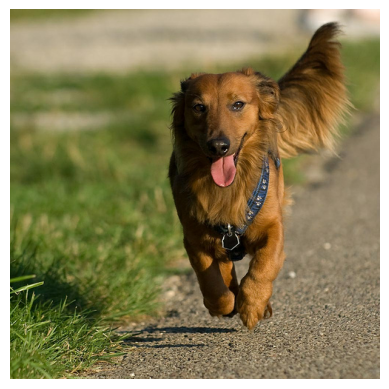

In [3]:
show_img('1089181217_ee1167f7af.jpg')

In [3]:
SIZE = (224, 224) # Docelowa wielkosc w jakiej bedziemy wczytywac obrazy

filename = "Flickr_8k.trainImages.txt"

path_to_info = "data/info_on_images/" + filename
path_to_image = "data/fetched/"

## 1.2 Stworzenie obiektu VGG16 - sieć neuronowa typu _backbone_, która posłuży do wyciągnięcia wektorów cech

Poniższy model posłuży do ekstrakcji wektora cech. Jak to zostało wspomniane we wstępie, pomijamy ostatnią warstwę.


In [8]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

## 1.3 Wyciagniecie wektorow cech z obrazow

Poniższa funkcja pozwoli na wyciągniecie wektorów cech z podzbioru danych. Należy jednak zwrócić na używaną zmienną `SIZE`, której wartość jest inicjalizowana wcześniej w _notebook'u_. Zdjęcia ze zbioru danych, będą ograniczone do zadanej wartości. Ustalenie tej wartości, jest uwarunkowane używanym modelem.

In [4]:
def get_features(path_to_images, path_to_ids):
    global SIZE
    features_vectors = {}

    with open(path_to_ids, "r") as file:
        data = file.read().splitlines()

    for image_name in data:
        image = load_img(path_to_images + image_name, target_size=SIZE)
        image = img_to_array(image)
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

        image = preprocess_input(image)

        feature = model.predict(image, verbose=0)

        features_vectors[image_name] = feature
    return features_vectors

In [ ]:
dump(get_features(path_to_image, path_to_info), open(os.path.join("utils", "features_inception.pkl"), "wb"))

## 1.4 Podsumowanie modelu

Poniżej jest przedstawiona poglądowa architektura modelu _VGG16_. Można zauważyć mnogość warstw konwolucyjnych, które mają duże znaczenie z perspektywy zadania przetwarzania obrazów.

Warstwy typu _pooling_, służą do ograniczania wielowymiarowości. W tym przypadku, wartością reprezentująca obszar, jest wartość maksymalna z obszaru.

_Flatten_ nie jest warstwą neuronów, a można to rozumieć jako sprowadzenie wielowymiarowych danych na wejściu warstwy do jednowymiarowego wektora.

Jak widzimy, model na wejściu otrzymuje obraz wielkości 224x224x3, a wyjsciem jest wektor wielkości 1x4096.

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

---

# 2. Wstepne przetwarzanie danych tekstowych

Przed podaniem danych modelowi, należy je przetworzyć. W celu nauczenia rekurencyjnych sieci neuronowych, nasze podpisy do obrazków muszą być przedłużone, poprzez dodanie na koniec tokenu stopu - w naszym przypadku _endseq_, oraz tokenu startu - w naszym przypadku _startseq_. Owe tokeny, nie mogą być jednymi ze słów ze słownika opisów.

## 2.1 Definicja tokenów i wyrazów do usunię|cia

Tokenizacja to nic innego jak podział tekstu na mniejsze części. Tokenami mogą być wyrazy, litery, znaki interpunkcyjne, w zależności od kontekstu i przeznaczenia. 

Tokeny, posłużą nam do stworzenia słownika opisów, czyli zbioru słów z których składają się przygotowane opisy, a w procesie uczenia tokeny, zostaną przedstawione w postaci liczb. Model statystyczny nie rozumie słów tak jak człowiek, który się nauczył ich znaczenia empirycznie. Tokeny, należy przedstawić w formie liczbowej, tak aby ten dzięki skomplikowanym mechanizmom, potrafił _łączyć kropki_ i wyznaczał korelacje między tokenami.

Sam model, na wyjściu będzie generował wektor liczb, gdyż jak wiemy model sztucznej inteligencji, jest modelem statystycznym, więc operuje na liczbach. Generowane liczby, nie są przypadkowe, a będą to indeksy Tokenów właśnie. Naszym zadaniem, będzie później ten wektor odkodować.

Jako początek sekwencji, będziemy używali tokenu _startseq_, a do zakonczenia sekwencji uzyjemy _endseq_. Seperator, pozwoli w naszej implementacji oddzielić ID zdjęcia od jego opisu.

In [5]:
BEGIN = 'startseq'
END = 'endseq'
SEP = '###'

In [6]:
def is_stop_token(text):
    """
    Funkcja sprawdzajaca, czy wyraz jest tokenem poczatkowym/koncowym.
    :param: str text - wyraz do sprawdzenia
    
    :returns: boolean True - wyraz jest tokenem stopu / boolean False - nie jest tokenem stopu
    """
    global BEGIN, END
    return text == BEGIN or text == END


def text_preprocessing(text):
    """
    Funkcja, ktora wstepnie przetwarza cala linijke textu w nastepujacej kolejnosci:
    1. Zamienia wszystkie litery na male.
    2. Zamienia kazdy znak, ktory ani nie jest alfanumeryczny, ani nie jest spacja, na pusty znak.
    3. Zamienia wiele spacji na pojedyncza spacje.
    4. Usuwa znaki biale na koncu zdania.
    5. Dodaje tokeny poczatku i konca zdania.
    
    :param: str text - linijka do przetwarzania
    
    :returns: str text - przetworzona linijka
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    text = BEGIN + ' ' + text + ' ' + END
    text = list(filter(lambda x: (is_stop_token(x) or len(x) > 1) and not x.isnumeric(), text.split()))
    text = " ".join(text)

    return text

Jak widać powyżej, w naszej implementacji, opisy są przetwarzane w następujący sposób:
- wszystkie litery sprowadzamy do małych liter
- usuwamy wszystkie znaki niebędące znakiem białym, lub literą
- dodajemy tokeny startu i stopu
- pozbywamy się słów skladających się z jednej litery

Dzięki powyższym operacjom, znacząco upraszczamy nasze zadanie, gdyż zmniejszami skomplikowanie zdań opisów. Oczywiście, należy pamiętać, że takie operacje mają wpływ na generowane opisy. Usunięcie wszystkich liczb powoduje, że model nigdy nie wygeneruje jakiejkolwiek liczby, gdyż nigdy do tego nie zostanie nauczony.

Poniższe funkcje są ważne ze względu na implementację, jednak nie mają znaczenia z perspektywy problemu. Dzięki nim, możemy wczytać konkretny plik, wyciągnąć opisy z przygotowanego pliku, stworzenie słownika opisów, zapisanie opisów.

In [7]:
def load_file(path):
    """
    Wczytuje plik tekstowy do pamieci czytajac go calego na raz i dzieli go ze wzgledu na znaki nowej linii.
    
    :param: str path - sciezka do pliku tekstowego
    
    :returns: list[str] text - wczytany plik w postaci listy linijek z pliku
    """
    with open(path, 'r') as file:
        text = file.read().splitlines()
    return text


def get_descriptions(text):
    """
    Przeczytaj plik z opisami zdjec i zwroc slownik, ktory danemu ID przyporzadkowuje wszystkie opisy do zdjec.
    
    :param: list[str] text - lista linijek opisujacych zdjecie w nastepujacym formacie - ID# OPIS
    
    :returns: dict[str, list[str]] - slownik, ktory danemu ID (str), przyporzadkowuje liste (list[str]) opisow do
    danego zdjecia.
    """
    descriptions = {}

    for line in text:
        id, desc = re.split('#\d\s+',line)
        if id not in descriptions:
            descriptions[id] = []
        descriptions[id].append(text_preprocessing(desc))
    return descriptions


def to_bag_of_words(descriptions):
    """
    Zwraca zbior wszystkich opisow. Opisy w formie tekstow, sa zamieniane na listy, podzielone ze wzgledu na znak
    spacji.
    
    :param: dict[str, list[str]] - slownik z opisami zdjec (patrz get_descriptions)
    
    :returns: set[str] - zbior wszystkich wyrazow, ktore zostaly uzyte do opisow zdjec.
    """
    
    words = set()
    for key in descriptions.keys():
        [words.update(w.split(' ')) for w in descriptions[key]]
    return words


def save_descriptions_to_a_file(descriptions, path):
    """
    Zapisuje slownik do pliku w sciezce 'path'. Slownik zapisywany jest w nastepujacym formacie: ID{seperator}OPIS.
    
    :param: dict[str, list[str]] - slownik z opisami zdjec (patrz get_descriptions).
    :param: str path - sciezka do pliku
    
    :returns: None
    """
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + SEP + desc)
    data = '\n'.join(lines)
    file = open(path, 'w')
    file.write(data)
    file.close()

## 2.2 Wczytanie pliku z opisami do zdjec

In [8]:
filename = 'data/info_on_images/Flickr8k.token.txt'
doc = load_file(filename)

## 2.3 Ekstrakcja opisow do zdjec

In [9]:
descriptions = get_descriptions(doc)
print('Liczba wczytanych opisow: %d ' % len(descriptions))

Liczba wczytanych opisow: 8092 


## 2.4 Stworzenie slownika wszystkich slow uzytych do opisow zdjec

In [10]:
vocabulary = to_bag_of_words(descriptions)
print('Wielkosc slownika: %d' % len(vocabulary))

Wielkosc slownika: 8773


In [27]:
save_descriptions_to_a_file(descriptions, 'utils/descriptions.txt')

---

# 3. Przygotowanie do uczenia modelu

## 3.1 Funkcje odpowiedzialne za proces tokenizacji podczas przetwarzania tekstu

Prócz samego tokenizatora, który mapuje słowa do liczb (indeksacja), potrzebujemy też obiektu do niego odwrotnego. Dzięki temu będziemy w stanie zakodować słowa, jednak po wygenerowaniu liczbowego przedstawienia opisu w postaci wektora liczb, będziemy potrzebowali odkodować te liczby, w tym celu stworzymy też obiekt _odwrotny_ do tokenizatora.

In [11]:
def create_tokenizer(description_list):
    """
    Tworzy obiekt klasy Tokenizer na podstawie listy wszystkich opisow.
    
    :param: list[str] description_list  - lista wszystkich opisow
    
    :returns: tokenizer
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(description_list,)
    return tokenizer

def get_reverse_tokenizer(tokenizer: Tokenizer):
    """
    Odwraca dzialanie tokenizacji.
    Jako ze Tokenizer domyslnie, dopasowuje napis do liczby, to nalezy rowniez ten proces odwrocic, aby
    odkodowac przewidziany opis.
    
    :param: Tokenizer tokenizer - obiekt tokenizer z biblioteki keras
    
    :returns: dict[int, str] - slownik przypisowujacy liczbie, odpowiadajacy jej napis
    """
    return {v:k for (k,v) in tokenizer.word_index.items()}

#### Przyklad:

In [15]:
tok = create_tokenizer(['A dog is running', 'A kid is playing on a playground with their dog'])
tok.word_index

{'a': 1,
 'dog': 2,
 'is': 3,
 'running': 4,
 'kid': 5,
 'playing': 6,
 'on': 7,
 'playground': 8,
 'with': 9,
 'their': 10}

Powyżej, bardzo dobrze widać, że tokenizer nadaje niższe indeksy, tokenom które częściej wystepują w opisach.

## 3.2 Funkcje pozwalajace na podawanie opisów do modelu

Proponowane rozwiązanie używa _generatora_, który posłuży za podawanie kolejnych wartości. Maszyna, na ktorej trenowany będzie model ma tylko 16GB pamieci RAM, takze niemożliwe będzie załadowanie do pamięci na raz 6000 opisów do obrazów.

Poniższa funkcja pozwala wygenerować wszystkie możliwe sekwencje opisów. Rekurencyjna sieć neuronowa uczy się na podstawie tychże sekwencji, dzięki temu model potrafi w podobny sposób do poniższego predykować następne słowa:

_Przykład 1_:

    Wejście: startseq Man standing in 
    Output: the


_Przykład 2_:

    Wejście: startseq Dog is running through the
    Output: field

W połączeniu z wektorami cech, nasz model będzie w stanie generować następne słowa, zgodnie z tym co przedstawia obrazek.

In [12]:
def create_sequences(tokenizer, max_length, desc_list, feature, vocab_size):
    """
    Tworzy sekwencje wejściowe i wyjściowe dla opisów obrazków dla rekurencyjnych sieci neuronowych, ktore
    predykuja nastepne slowo na podstawie sekwencji. np:
    input seq: startseq a dog is 
    output seq: running

    :param: Tokenizer tokenizer -  obiekt tokenizer z biblioteki keras
    :param: int max_length: maksymalna długość sekwencji
    :param: list[str] desc_list  - lista opisów obrazków
    :param: np.array feature - wektor cech obrazow
    :param: int vocab_size - rozmiar słownika
    
    :return: trzy wartości: macierz z cechami obrazów, 
        macierz sekwencji wejściowych oraz macierz sekwencji wyjściowych
    """
    photo_for_seq, input_sequences, output_for_seq = [], [], []
    
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            # input sekwencja do i-tego wyrazu, a output to i-ty wyraz
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            # dodaj do arrays nastepujace elementy: wektor_cech, input_sequence, output_sequence
            photo_for_seq.append(feature)
            input_sequences.append(in_seq)
            output_for_seq.append(out_seq)
    return array(photo_for_seq), array(input_sequences), array(output_for_seq)

Proponowane rozwiązanie używa _generatora_, który posłuży za podawanie kolejnych wartości. Maszyna, na której trenowany będzie model ma tylko 16GB pamieci RAM, takze niemożliwe bedzie załadowanie do pamięci na raz 6000 opisów do obrazów.

In [13]:
def generate_data(descriptions, features, tokenizer, max_length, vocab_size):
    """
    Pythonowy generator, ktory 'oddaje' sekwencje do modelu RNN (rekurencyjna siec neuronowa).
    
    :param: dict[str, list[str]] descriptions - opisy do zdjec (patrz get_descriptions)
    :param: features[str, ]
    """
    while 1:
        for key, desc_list in descriptions.items():
            feature = features[key][0]

            input_img, input_seq, output_seq = create_sequences(tokenizer, max_length, desc_list, feature, vocab_size)
            yield [[input_img, input_seq], output_seq]

## 3.4 Funkcje pomocnicze

Do trenowania modelu, będziemy też potrzebowali funkcji, które pozwola nam określić długość najdłuższej sekwencji, którą model powinien generować, wielkość słownika (tokenizer), oraz funkcji która pozwoli _wypłaszczyć_ dwuwymiarową liste, do jednowymiarowej.

In [14]:
def max_len(flattened_descriptions):
    """
    Zwraca dlugosc najdluzszego opisu do zdjec.
    
    :param: list[str] flattened_descriptions - wszystkie opisy do zdjec.
    
    :returns: int x - dlugosc najdluzszego opisu.
    """
    return max((len(l.split()) for l in flattened_descriptions))



def size_of_vocab(tokenizer):
    """
    Zwraca wielkosc slownika. 
    
    :param: Tokenizer tokenizer - obiekt tokenizer z biblioteki keras
    
    :returns: int x - wielkość docelowego słownika
    """
    return len(tokenizer.word_index) + 1

def flatten_descriptions(descriptions):
    """
    Splaszcza opisy obrazkow. Tworzy ze slownika (ktory do klucza przypisane ma wiele opisow), 
    liste jednowymiarowa tychze opisow.
    
    :param: dict[str, list[str]] descriptions - slownik opisow obrazkow (patrz get_descriptions)
    
    :returns: list[str] - slownik przypisowujacy liczbie, odpowiadajacy jej napis
    """
    return [item for sub in descriptions.values() for item in sub]

#### Przykład

In [27]:
desc = {"1":["a","b","c"],"2":["d","e","jestem wesoly"]}
flatten_descriptions(desc)

['a', 'b', 'c', 'd', 'e', 'jestem wesoly']

In [28]:
max_len(flatten_descriptions(desc))

2

---

# 4. Wczytanie przetworzonych danych

Potrzebujemy wczytać do pamięci _zapiklowane_ wcześniej obiekty (przetworzone opisy, wektory cech), żeby wykorzystać w procesie uczenia.

In [15]:
def get_clean_descriptions(image_ids, descriptions_path):
    """
    Zwraca zapisane opisy juz po wczesnym przetwarzaniu (patrz save_descriptions_to_file). 
    
    :param: list[str] image_ids - lista id obrazow
    :param: str descriptions_path - sciezka do pliku z opisami
    
    :returns: dict[str, list[str]] - slownik, ktory przyporzadkowuje zdjeciu wszystkie przetworzone opisy
    """
    descriptions = load_file(descriptions_path)
    descriptions = list(map(lambda x: x.split(SEP), descriptions))
    multiple_descriptions = {}
    for k,v in descriptions:
        if k not in image_ids:
            continue
        elif k not in multiple_descriptions:
            multiple_descriptions[k] = []
        multiple_descriptions[k].append(v)

    return multiple_descriptions


def get_feature_vector(image_ids, features_path):
    """
    Zwraca zapisany dziennik, ktory jest ograniczony do tych kluczy z image-ids
    
    :param: list[str] image_ids - lista id obrazow
    :param: str features_path - sciezka do pliku ze spiklowanym slownikiem
    
    :returns: dict[str, np.array] - zapisany slownik
    """
    features_vectors = load(open(features_path, 'rb'))
    return {k:v for (k,v) in features_vectors.items() if k in image_ids}

### Na podstawie poniższego pliku, będzie trenowany model, zmiana pliku na walidacyjny/testowy/treningowy pozwala wytrenować/przetestować model.

In [16]:
filename = 'data/info_on_images/Flickr_8k.trainImages.txt'

In [17]:
descriptions = get_clean_descriptions(load_file(filename), 'utils/descriptions.txt')
flatten = flatten_descriptions(descriptions)

features = get_feature_vector(descriptions.keys(), 'utils/features.pkl')
tokenizer = create_tokenizer(flatten)

length = max_len(flatten)
size = len(to_bag_of_words(descriptions))

In [52]:
dump(tokenizer, open('utils/tokenizer.pkl','wb'))

#### Przykład

In [18]:
file_path = 'data/info_on_images/Flickr_8k.trainImages.txt'

train_images = load_file(file_path)
features = load(open("utils/features.pkl","rb"))
descriptions = get_clean_descriptions(train_images, "utils/descriptions.txt")
flatten_description = flatten_descriptions(descriptions)
tokenizer = create_tokenizer(flatten_description)

vocab_size = size_of_vocab(tokenizer)
max_length = max_len(flatten_description)

# pojedynczy obrazek
id_obrazka = '2513260012_03d33305cf.jpg'
feature = features[id_obrazka]
desc = descriptions[id_obrazka]

a,b,c = create_sequences(tokenizer,max_length,desc,feature,vocab_size)

#### Poniższy wynik, przedstawia kolejno: wektor cech, wektory danych wejściowych do RNN, wektory danych wyjściowych z RNN

In [33]:
a[:10],b[:10],c[:10]

(array([[[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        ...,
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]],
 
        [[0.       , 0.       , 1.7041475, ..., 0.       , 0.       ,
          0.       ]]], dtype=float32),
 array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0, 

In [35]:
koncowka_opisu = b[-1][27:]
koncowka_opisu

array([  2,  13,  31,  32,  33,   1, 534, 445, 260,  12,  24], dtype=int32)

In [36]:
r = get_reverse_tokenizer(tokenizer)

res = ""

for slowo in koncowka_opisu:
    res += r[slowo] + " "

In [37]:
res

'startseq two dogs running through a low lying body of water '

---

# 5. Trenowanie modelu

<div style="text-align:center">
    <img src="utils/model.png" alt="Image" width="600">
</div>


Poniższa funkcja pozwala na stworzenie samego modelu. Architektura naszego modelu, jest przedstawiona na powyższym zdjęciu. Jak widzimy mamy dwie gałęzi, jedna odpowiedzialna za przetworzenie danych tekstowych, a druga odpowiedzialna za przetwarzanie zdjeć.

Zwróćmy uwagę, że model maksymalnie może przyjać opis, którego długość nie przekracza 34 tokenów, czyli tyle ile tokenów znajduje się w najdłuższym opisie.

Druga gałąź, zgodnie z tym co wcześniej zostało opisane, przyjmuje wektor cech o wielkosci 1x4096.

Podczas przetwarzania tekstu, dane przechodzą przez warstwę _embedding_, która pozwala na przetworzenie indeksów tokenów na gęste wektory zwane _embeddingami_, czyli macierzy o wielkości _rozmiar słownika_ x _rozmiar embeddingu_ ( wnaszym przypadku 256). Dzięki temu, prócz samych zależności między indeksami tokenów, model jest w stanie wychwycić semantykę języka i jest w stanie lepiej dostosować się do zbioru danych.

Kolejna warstwa, nie jest warstwą neuronów, a służy jedynie celom regulacyjnym, dzięki czemu model nie zostanie przetrenowany na zbiorze treningowym. Warstwa ta, pozwala na _wyłączenie_ neuronów w procesie uczenia, dzięki czemuwartości przechodzące przez wyłączone neurony, nie są przekazywane dalej, a w procesie wstecznej propagacji, wagi uwzględniające wyłączony neuron, nie są dostosowywane.

Ostatnią warstwą jest LSTM (eng. Long Short-Term Memory), czyli rekurencyjna warstwa neuronowa, która pozwala na modelowanie sekwencji danych. LSTM powstało jako odpowiedź na problem zanikającego gradientu, kiedy to początkowe wartości mają małe znaczenie dla predykcji. Warstwa wprowadza trzy _bramki_, które pozwalają na sterowanie przepływem informacji. Jedna z bramek, decyduje o tym które informacje z poprzedniego stanu powinny być zapomniane, jakie powinny być uwzględnione z aktualnego wejścia, oraz jakie powinny zostać przekazane na wyjście.

Warstwy w pełni połączone (eng. _Dense_), łączą neurony poprzedniej warstwy, ze wszystkimi neuronami z warstwy aktualnej. Jest to najbardziej zasobochłonna warstwa do nauczenia, gdyż dzięki niej powstaje ogromna ilość parametrów, które mogą być dostosowywane w procesie wstecznej propagacji. Jest to podstawowa warstwa sieci neuronowych, gdyż ma wiele zastosowań, jednak jej podstawową jest modelowanie nieliniowych zależności między cechami wejściowymi a wyjściem modelu.

Obie gałęzi, są połączone warstwą _Add_, gdzie po prostu wyjścia obydwu gałęzi o wymiarach odpowiednio 1x256 i 1x256, są sumowane do wektora o tym samym wymiarze.

Dalsze warstwy to tylko i wyłącznie warstwy typu Dense, gdzie ostatnia jest rozszerzana do wielkości 1x _wielkość słownika_.

In [19]:
def create_model(vocab_size, max_length_of_seq):
    """
    Tworzy model zgodnie z architektura, przedstawiona w katalogu utils/model.png. Model sluzy do generacji
    opisu do obrazka podanego na wejsciu modelu przy predykcji.
    
    :param: int vocab_size - wielkosc slownika
    :param: int max_length_of_seq - maksymalna dlugosc generowanego zdania
    
    :returns: keras.model.Model - model
    """
    image_input = Input(shape=(2048,))
    image = Dropout(0.25)(image_input)
    image = Dense(256, activation='relu')(image)

    sequences_input = Input(shape=(max_length_of_seq,))
    sequences = Embedding(vocab_size, 256, mask_zero=True)(sequences_input)
    sequences = Dropout(0.25)(sequences)
    sequences = LSTM(256)(sequences)

    decoder = add([image, sequences])
    decoder = Dense(256, activation='relu')(decoder)
    output = Dense(vocab_size, activation='softmax')(decoder)

    model = Model(inputs=[image_input, sequences_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    plot_model(model, to_file='utils/model.png', show_shapes=True)

    return model

Potrzebna tez jest funkcja ktora pozwoli na samo trenowanie modelu. Wykorzystamy w tym celu wczesniej utworzone funkcje, miedzy innymi wczytywanie opisow, wektorow cech, tworzenia modelu itd.

Po kazdej epoce, model bedzie zapisywany w katalogu _models_. Jak wcześniej zostało wspomniane, w naszej implementacji wykorzystamy generator.

In [20]:
def train_model(file_path, epochs, model, c=-1):
    """
    Trenuje model, w oparciu o plik z opisami w file_path. Po jednej epoce, model jest zapisywany w models/
    
    :param: str file_path - sciezka do pliku z przetworzonymi opisami
    :param: int epochs - liczba epok
    :param: keras.model.Model model - model do wytrenowania
    :param: int c - liczba obrazow, ktora jest brana pod uwage przy trenowaniu    
    :returns: None
    """
    train_images = load_file(file_path)
    
    if c != -1:
        train_images = load_file(file_path)[:c]
        
    features = get_feature_vector(train_images, "utils/features_inception.pkl")
    descriptions = get_clean_descriptions(train_images, "utils/descriptions.txt")
    flatten_description = flatten_descriptions(descriptions)
    tokenizer = create_tokenizer(flatten_description)

    vocab_size = size_of_vocab(tokenizer)
    max_length = max_len(flatten_description)
    model = create_model(vocab_size, max_length)

    steps = len(descriptions)
    for i in range(epochs):
        gen = generate_data(descriptions, features, tokenizer, max_length, vocab_size)
        model.fit_generator(gen, epochs=1, steps_per_epoch=steps,verbose=1, max_queue_size=500, use_multiprocessing=True)
        model.save('models/model_inceptionv3_V' + str(i) + '.h5')

In [21]:
filename = 'data/info_on_images/Flickr_8k.trainImages.txt'

In [22]:
SIZE = (224,224)

In [ ]:
train_model(filename, 20, create_model(size, length))

---

# 6. Ewaluacja modelu

Samo wytrenowanie modelu nie wystarczy, trzeba przede wszystkim sprawdzić jego dzialanie na pojedynczym zdjęciu, oraz trzeba sprawdzić jego wydajnosc na innym zbiorze danych.

## 6.1 Funkcje pomocnicze

In [23]:
def get_clean_descriptions(filename, photo_ids):
    descs = get_descriptions(load_file(filename))
    return {k:v for (k,v) in descs.items() if k.split('.')[0] in photo_ids}

def get_photo_ids(filename):
    text = load_file(filename)
    return [i.split('.')[0] for i in text]

def extract_features(path_image, model):
    image = load_img(path_image, target_size=SIZE)
    image = img_to_array(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    image = preprocess_input(image)

    return model.predict(image, verbose=0)

## 6.2 Metryka BLEU

Do ewaluacji naszego modelu, wykorzystamy metrykę BLEU, która (w dużym uproszczeniu) wylicza iloraz jako ilość kombinacji słów w generowanym opisie, które się pojawiają w referencyjnym opisie, do ilości kombinacji słów. Należy zwrócić uwagę, że ta metryka ma swoje wady i niekoniecznie może mieć znaczenie w każdej implementacji, jednak w tym przypadku jest wystarczająca do wyciągnięcia wniosków o jakości wytrenowanego modelu.

In [47]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    """
    Ocenia model poprzez porównanie przewidywanych opisów z rzeczywistymi opisami dla podanych danych.
    
    :param model: Model RNN, który ma być oceniany.
    :param descriptions: Słownik opisów dla poszczególnych zdjęć.
    :param photos: Słownik zdjęć, dla których mają być generowane opisy.
    :param tokenizer: Tokenizer używany do tokenizacji danych tekstowych.
    :param max_length: Maksymalna długość generowanego opisu.
    """
    y, y_pred = [], []
    for k, desc_list in descriptions.items():
        predicted_description = predict_description(model, tokenizer, photos[k], max_length)
        refs = [desc.split() for desc in desc_list]
        y.append(refs)
        y_pred.append(predicted_description.split())
    print('BLEU-1: %f' % corpus_bleu(y, y_pred, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(y, y_pred, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(y, y_pred, weights=(0.333, 0.333, 0.3331, 0)))
    print('BLEU-4: %f' % corpus_bleu(y, y_pred, weights=(0.25, 0.25, 0.25, 0.25)))
    

## 6.3 Predykcja opisu

Funkcja, która posłuży za generowanie opisu, polega na generowaniu następnych indeksów tokenów na podstawie poprzednio wygenerowanych. Będzie się to działo tak długo, dopóki wygenerowany indeks nie będzie tokenem stopu.

Jak pamiętamy, jednym z wejść naszego modelu powiniene być wektor 1x34, jednak z początku napis jest tylko i wyłącznie tokenem startu. W tym celu stosuje się tzw. _padding_, czyli wypełnienie wektora zerami, tak żeby ten miał zadaną długość.

In [25]:
def predict_description(model, tokenizer: Tokenizer, photo, max_length):
    """
    Generuje tekstowy opis dla podanego obrazu, używając wytrenowanego modelu RNN.
    
    :param model: Wytrenowany model RNN używany do generowania opisów.
    :param tokenizer: Tokenizer używany do tokenizacji danych tekstowych.
    :param photo: Wejściowy obraz, dla którego ma zostać wygenerowany opis.
    :param max_length: Maksymalna długość wygenerowanego opisu.
    :return: Przewidywany tekstowy opis dla podanego obrazu.
    """

    input = BEGIN
    reversed_tokenizer = get_reverse_tokenizer(tokenizer)
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([input])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_predict = model.predict([photo, sequence], verbose=0)
        y_predict = argmax(y_predict)

        predicted_word: str = reversed_tokenizer[y_predict]

        if predicted_word == None:
            break

        input += " " + predicted_word

        if predicted_word == END:
            break
    prediction = input
    prediction = " ".join(prediction.split(" ")[1:-1]).capitalize()
    return prediction

## 6.4 Ewaluacja

### 6.4.1 Ekstrakcja wektorow cech

####  VGG16

In [64]:
vextractor = VGG16()
vextractor = Model(inputs=vextractor.inputs, outputs=vextractor.layers[-2].output)

#### InceptionV3

In [46]:
iextractor = InceptionV3()
iextractor = Model(inputs=iextractor.inputs, outputs=iextractor.layers[-2].output)

### 6.4.2 Predykcja podpisu do obrazka

In [65]:
photo = extract_features('./dog.jpg', vextractor)
photo

array([[0.       , 0.       , 4.7995973, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

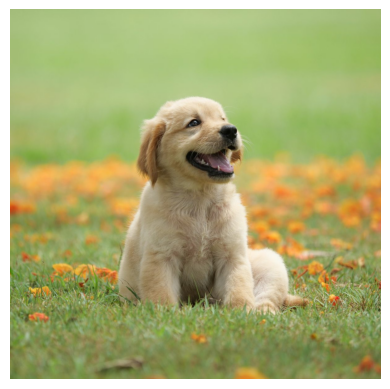

In [66]:
plt.axis('off')
plt.imshow(decode_jpeg(read_file('dog.jpg'), channels=3));

In [56]:
model = load_model('models/model_vgg.h5')
path_to_img = './dog.jpg'

tokenizer = load(open('utils/tokenizer.pkl', 'rb')) # wciągnięcie słownika i tokenów

predict_description(model, tokenizer, photo, 34)

'Dog is running through the grass'

# Wnioski

Jak widać, model dość dobrze poradził sobie z predykcją podpisu do wyżej pokazanego obrazka.

Widać, że poradził sobie z rozpoznaniem psa, jak i trawy. Nie poradził sobie natomiast z rozpoznaniem ruchu wykonywanego przez psa. Może być to spowodowane obrazami, na podstawie których model był uczony, lub fakt że po prostu model ma za mało danych, aby prócz podmiotu zdjęcia, rozpoznał też takie szczegóły jak ruch obiektu.

Jeśli większość psów, które model dostawał w procesie uczenia, wykonywała czynność biegania, to też model z większą pewnością, był w stanie stwierdzić, że jeśli na obrazie już zlokalizował psa, to też pewnie ten pies będzie biegł. 

Aby temu zapobiec, należałoby zwiększyć liczbę obiektów, na podstawie których model był uczony, lub dokonać procesu tzw. _image augmentation_, gdzie zwiększamy liczbę obrazów poprzez tworzenie nowych zdjęć, za pomocą zmiany jasności, obrotu zdjęcia, zmiany kolorystyki itd..

In [64]:
model = VGG16()
model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [ ]:
test_path = 'data/info_on_images/Flickr_8k.testImages.txt'
descriptions_path =  'data/info_on_images/Flickr8k.token.txt'
ids = get_photo_ids(test_path)
descs = get_clean_descriptions(descriptions_path, ids)
features = get_features('data/fetched/', test_path)

In [ ]:
model = load_model('models/model_vgg.h5')

In [289]:
evaluate_model(model, descs, features, tokenizer, length)

BLEU-1: 0.330521
BLEU-2: 0.168503
BLEU-3: 0.109997
BLEU-4: 0.046214


Jak widać, na podstawie powyższych wyników, ciężko stwierdzić, czy wydajność modelu jest wystarczająca. Metryka BLEU, pozwala na ewaluacje jakości modelu translacyjnego. Mierzy ona podobieństwo między wygenerowanym przez maszynę tekstem, oraz tekstem referencyjnym, przy użyciu n-gramów. W tym przypadku, widzimy że model był w stanie poprawnie wygenerować 23% bigramów, czyli par tokenów, które się pokrywały z tekstem referencyjnym.

---

# 7. Przykłady dzialania modelu

In [26]:
from random import choice
count = 4
path = 'data/fetched'
ids = [choice(os.listdir(path)) for _ in range(count)]
ids

['3404012438_9baf8dcbaf.jpg',
 '447800028_0242008fa3.jpg',
 '892340814_bdd61e10a4.jpg',
 '179009558_69be522c63.jpg']

2805873509_4f68afc4b4.jpg#0	A guy with a backpack on .

2805873509_4f68afc4b4.jpg#1	A hiker is standing by a mound of rocks on the path .

2805873509_4f68afc4b4.jpg#2	A man hikes up a rocky hill .

2805873509_4f68afc4b4.jpg#3	A man with a backpack on a hill next to a rock outcroping .

2805873509_4f68afc4b4.jpg#4	A man with a backpack stands beside a rock .



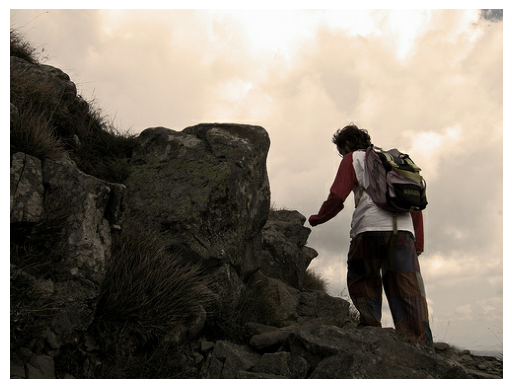

In [253]:
identyfikator = ids[0]
show_img(identyfikator)

In [254]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), 34)

'Man in red shirt is climbing up rock face'

3516285214_59823b341e.jpg#0	A person surfs in the curl of a wave , obsured by the falling water .

3516285214_59823b341e.jpg#1	A person surfs through a wave as it crashes down .

3516285214_59823b341e.jpg#2	A surfer is riding in the barrel of a wave .

3516285214_59823b341e.jpg#3	Someone is surfing underneath a wave on a white surfboard .

3516285214_59823b341e.jpg#4	The large wave is crashing down over a surfer .



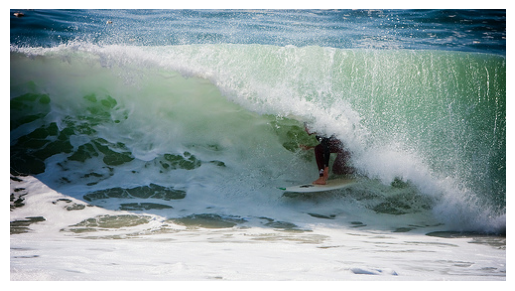

In [255]:
identyfikator = ids[1]
show_img(identyfikator)

In [256]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor),210)

'Man in blue bathing suit is swimming in the water'

3192311620_99bda27fbd.jpg#0	A brown dog is about to catch a treat .

3192311620_99bda27fbd.jpg#1	A brown dog opens his mouth to catch a piece of food .

3192311620_99bda27fbd.jpg#2	A dog is about to catch a treat in his mouth .

3192311620_99bda27fbd.jpg#3	A dog opens its mouth to catch a treat

3192311620_99bda27fbd.jpg#4	The dog is catching a treat .



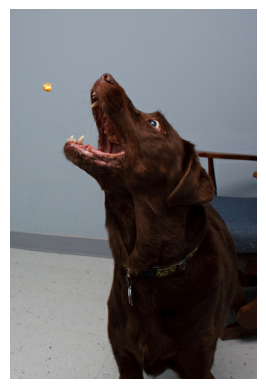

In [257]:
identyfikator = ids[2]
show_img(identyfikator)

In [258]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), length)

'Dog is running through the grass'

2662262499_3cdf49cedd.jpg#0	A baseball hitter holding a bat falling down .

2662262499_3cdf49cedd.jpg#1	A baseball player runs on the field .

2662262499_3cdf49cedd.jpg#2	A boy at bat playing a baseball game falls to the ground while onlookers watch .

2662262499_3cdf49cedd.jpg#3	A child in a uniform is falling to the ground with a bat in his or her hand .

2662262499_3cdf49cedd.jpg#4	This baseball player , dressed in red and white uniform and holding a bat , is falling after being hit by a pitch .



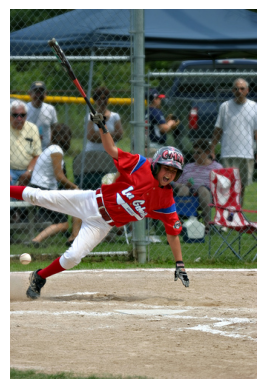

In [259]:
identyfikator = ids[3]
show_img(identyfikator)

In [260]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), length)

'Two men are playing soccer'

Jak widać model poprawnie potrafił rozpoznać główne obiekty na obrazie. Ze względu na ograniczenia sprzętowe, jest to model, który był trenowany dwie epoki. Wraz z kolejnymi epokami, model potrafiłby coraz lepiej dostrzegać szczegóły obrazu.

---

# 8. Przykłady opisu do zdjęcia i metryki dla obu modeli 

## 8.1 VGG16

In [412]:
extractor = VGG16()
extractor = Model(inputs=extractor.inputs, outputs=extractor.layers[-2].output)
SIZE=(224,224)

In [413]:
model = load_model('models/model_vgg.h5')

In [431]:
identyfikator = '3051998298_38da5746fa.jpg'
path = path_to_image + identyfikator

3051998298_38da5746fa.jpg#0	A guy in navy blue and yellow shorts jumping into a pool .

3051998298_38da5746fa.jpg#1	A man catches a football in midair while jumping into a pool .

3051998298_38da5746fa.jpg#2	A man in swim trunks is jumping into a pool while in a strange pose

3051998298_38da5746fa.jpg#3	Antics in a covered pool .

3051998298_38da5746fa.jpg#4	People are diving into a swimming pool .



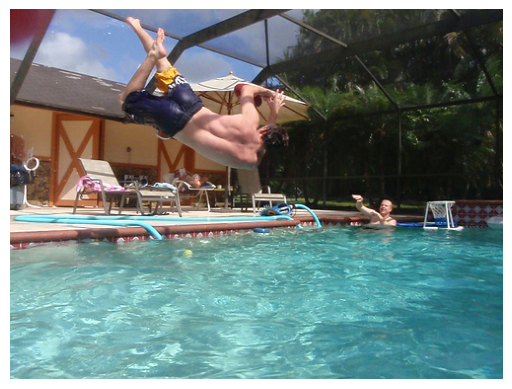

In [432]:
show_img(identyfikator)

In [433]:
predict_description(modelvgg, tokenizer, extract_features(path, extractor), length)

'Man in blue bathing suit is jumping into the water'

## 8.2 InceptionV3

In [434]:
model = load_model('models/model_inceptionv3_V1.h5')
extractor = InceptionV3()
extractor = Model(inputs=extractor.input, outputs=extractor.layers[-2].output)
SIZE = (299,299)

3051998298_38da5746fa.jpg#0	A guy in navy blue and yellow shorts jumping into a pool .

3051998298_38da5746fa.jpg#1	A man catches a football in midair while jumping into a pool .

3051998298_38da5746fa.jpg#2	A man in swim trunks is jumping into a pool while in a strange pose

3051998298_38da5746fa.jpg#3	Antics in a covered pool .

3051998298_38da5746fa.jpg#4	People are diving into a swimming pool .



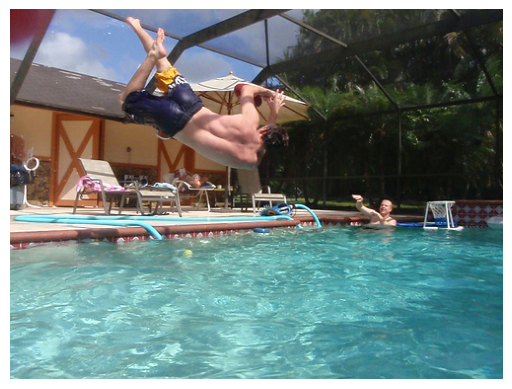

In [435]:
show_img(identyfikator)

In [436]:
predict_description(model, tokenizer, extract_features(path, extractor), length)

'Two people are sitting on the beach'

## 8.3 Metryki BLEU po wytrenowaniu dla całego zbioru danych

In [27]:
path = 'data/info_on_images/'
test_path = path + 'Flickr_8k.testImages.txt'
train_path = path + 'Flickr_8k.trainImages.txt'
dev_path = path + 'Flickr_8k.devImages.txt'
descriptions_path =  'data/info_on_images/Flickr8k.token.txt'

ids = get_photo_ids(train_path)
ids.extend(get_photo_ids(test_path))
ids.extend(get_photo_ids(dev_path))

descs = get_clean_descriptions(descriptions_path, ids)

In [31]:
from random import shuffle
PERCENTAGE = .1 # Metryki będą wyliczane dla X% zbioru danych
descs = list(descs.items())
shuffle(descs)
descs = descs[:int(len(descs)*PERCENTAGE)]
descs = dict(descs)

###  8.3.1 VGG16

#### Wczytanie modelu i danych

In [ ]:
model = VGG16()
model = Model(inputs=model.input, outputs=model.layers[-2].output)
path_to_info = 'data/info_on_images/'
extracted_features = get_features(path_to_image, train_path)
extracted_features.update(get_features(path_to_image, test_path))
extracted_features.update(get_features(path_to_image, dev_path))

In [27]:
dump(extracted_features, open(os.path.join("utils", "features.pkl"), "wb"))

In [ ]:
extracted_features = load(open('utils/features.pkl', 'rb'))
model = load_model('models/model_inceptionv3_V2.h5.h5')

#### Metryka BLEU-X

In [44]:
evaluate_model(model, descs, extracted_features, tokenizer, 34)

    
BLEU-1: 0.579114
BLEU-2: 0.344856
BLEU-3: 0.252154
BLEU-4: 0.131446


### 8.3.2 InceptionV3

#### Wczytanie modelu i danych

In [ ]:
model = InceptionV3()
model = Model(inputs=model.input, outputs=model.layers[-2].output)
SIZE = (299, 299)

extracted_features = get_features(path_to_image, train_path)
extracted_features.update(get_features(path_to_image, test_path))
extracted_features.update(get_features(path_to_image, dev_path))

In [ ]:
dump(extracted_features, open(os.path.join("utils", "features_inception.pkl"), "wb"))

In [42]:
extracted_features = load(open('utils/features_inception.pkl', 'rb'))
model = load_model('models/model_inceptionv3_V10.h5')

#### Metryka BLEU-X

In [46]:
evaluate_model(model,descs,extracted_features,tokenizer,38)

    
BLEU-1: 0.469374
BLEU-2: 0.312509
BLEU-3: 0.19745
BLEU-4: 0.114819


# Wnioski

Jak widać, model VGG16 potrafił znacznie lepiej rozpoznać obiekty na obrazku. Oba modele poprawnie rozpoznały tematykę, jednak to VGG16 znacznie lepiej sobie poradził w tym zadaniu. Oczywiście, nie można jednoznacznie stwierdzić, że model VGG16 jest _lepszym_ modelem. W kontekście tego zadania, gdzie mamy mało danych, bo blisko 6 tysięcy, ten model potrafił się lepiej dostosować do danych. 

Należy jednak zastanowić się i zwrócić uwagę, na problem przed jakim model został postawiony. Jak to zostało wcześniej wspomniane, problem _rozumowania_ rzeczywistości poprzez zmysł wzroku jest na tyle skomplikowany, że  człowiek uczy się dostosowywać do niego przez całe życie, a my próbujemy nauczyć tego matematyczną maszynę, której pokazujemy tylko i wyłącznie 6000 zdjęć i do każdego podajemy po pięć opisów do tego zdjęcia. Różnica w skali, jest tak ogromna, że w ten sposobów nie da się nauczyć modelu idealnego. Wadliwie przygotowane dane, również mają znaczenie, gdyż jeśli dwa opisy są ze sobą niezgodne tj. jeden z opisów do zdjęcia, opowiada o tle na obrazku, a drugi dotyczy osoby na zdjęciu, model nie będzie _pewien_, co konkretnie powinien opisać.

VGG16 jest modelem, który znacznie lepiej potrafi dokonać predykcji ogólnej tematyki obrazu, jak na przykład osoba skacząca do wody. Jendak ze względu na swoją architekturę, nie jest w stanie rozpoznoać szczegółów obrazu. Do tego celu, znacznie lepiej nadaje się model InceptionV3, który z łatwością potrafi wyciągnąć z obrazu takie informacje.

Warto również zwrócić uwagę na same metryki BLEU. Widać, że model VGG generuje lepsze opisy obrazów. Jest to spora różnica, między tym co generuje VGG, a co generuje InceptionV3. Jest to powiązane z faktem, iż InceptionV3 mimo że potrafi poprawnie rozpoznać szczegóły obrazu, takie jak tło, to słabo sobie z jakiegoś powodu radzi z tematem obrazu.

To, nad czym należałoby się zastanowić, to zastosowanie innej architektury modelu. W zastosowanej architekturze, dwie gałęzi idące od _inputu_ od zdjęcia i podpisu są od siebie niezależne, a łączone dopiero po przetwarzaniu. Jest to o tyle nieefektywne, że model uczy się jakie słowa występują po sobie, a nie jak one się mają do zdjęcia. Oczywiście, za sprawą łączenia obu gałezi warstwą _Add_, występuje pewna zależność między zdjęciem, a generowanym opisem, jednak relacja ta nie jest na tyle bezpośrednia, aby się przekładała na wyniki. 

Poniżej przedstawiona jest typowa architektura modelu tzw. _image captioning_ (pl. podpisywanie obrazów). Widzimy, że tak naprawdę, rekurencyjna sieć neuronowa, __wykorzystuje__ w procesie nauczania zdjęcie, dzięki czemu _RNN_ jest w stanie powiązać generowane słowa ze zdjęciem.

<div style="text-align:center">
    <img src="utils/captioning.png" alt="Image" width="600">
</div>


Poniżej, przedstawiona została wykorzystana przez nas, architektura która została zaproponowana, na blogu _machine leraning mastery_. Nie trudno zauważyć różnice. Za sprawą końcowych warstw _Add_ i _Dense_, nasz model ostatecznie i dość dobrze potrafi rozpoznać obiekt na obrazie, jednak nie jest to tak efektywne, jak mogłoby to być wykorzystując w tym celu inną architekturę.

<div style="text-align:center">
    <img src="utils/naive_architecture.webp" alt="Image" width="600">
</div>

